### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/workplace/aiffel/Exploration/09.RNN/ratings_train.txt')
test_data = pd.read_table('~/workplace/aiffel/Exploration/09.RNN/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

#### 3-1. 데이터셋 내 문장 길이 분포

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


#### 3-2. 적절한 최대 문장 길이 지정

In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### 3-3. keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4. 모델구성 및 validation set 구성
- 3가지 이상 이용

#### 4-1. 1-D CNN

In [9]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

#### 4-2. Word2Vec

In [10]:
import os
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/09.RNN/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [12]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
embeded_model = keras.Sequential()
embeded_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
embeded_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
embeded_model.add(keras.layers.MaxPooling1D(5))
embeded_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
embeded_model.add(keras.layers.GlobalMaxPooling1D())
embeded_model.add(keras.layers.Dense(8, activation='relu'))
embeded_model.add(keras.layers.Dense(1, activation='sigmoid')) 

embeded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 4-3. GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [14]:
gmp_model = keras.Sequential()
gmp_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(keras.layers.GlobalMaxPooling1D())
gmp_model.add(keras.layers.Dense(8, activation='relu'))
gmp_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


#### 4-4. Validation data 분리

In [15]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]



### 5. 모델 훈련 개시
#### 5-1. 1D-CNN

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
266/266 - 20s - loss: 0.4633 - accuracy: 0.7785 - val_loss: 0.3481 - val_accuracy: 0.8492
Epoch 2/20
266/266 - 1s - loss: 0.3227 - accuracy: 0.8637 - val_loss: 0.3362 - val_accuracy: 0.8538
Epoch 3/20
266/266 - 1s - loss: 0.2929 - accuracy: 0.8789 - val_loss: 0.3396 - val_accuracy: 0.8501
Epoch 4/20
266/266 - 1s - loss: 0.2670 - accuracy: 0.8922 - val_loss: 0.3427 - val_accuracy: 0.8513
Epoch 5/20
266/266 - 1s - loss: 0.2376 - accuracy: 0.9075 - val_loss: 0.3538 - val_accuracy: 0.8503
Epoch 6/20
266/266 - 1s - loss: 0.2058 - accuracy: 0.9234 - val_loss: 0.3825 - val_accuracy: 0.8457
Epoch 7/20
266/266 - 1s - loss: 0.1731 - accuracy: 0.9376 - val_loss: 0.4075 - val_accuracy: 0.8448
Epoch 8/20
266/266 - 1s - loss: 0.1439 - accuracy: 0.9503 - val_loss: 0.4486 - val_accuracy: 0.8392
Epoch 9/20
266/266 - 1s - loss: 0.1222 - accuracy: 0.9586 - val_loss: 0.4792 - val_accuracy: 0.8379
Epoch 10/20
266/266 - 1s - loss: 0.1032 - accuracy: 0.9660 - val_loss: 0.5274 - val_accuracy: 0.835

In [18]:
# 테스트셋 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.9373 - accuracy: 0.8156
[0.937260627746582, 0.8155705332756042]


#### 5-2. Word2Vec¶

In [19]:
embeded_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

embeded_history = embeded_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 16s 59ms/step - loss: 0.6149 - accuracy: 0.6320 - val_loss: 0.4274 - val_accuracy: 0.8030
Epoch 2/20
266/266 [==============================] - 7s 27ms/step - loss: 0.3875 - accuracy: 0.8282 - val_loss: 0.3592 - val_accuracy: 0.8394
Epoch 3/20
266/266 [==============================] - 7s 27ms/step - loss: 0.3337 - accuracy: 0.8569 - val_loss: 0.3754 - val_accuracy: 0.8319
Epoch 4/20
266/266 [==============================] - 7s 27ms/step - loss: 0.3077 - accuracy: 0.8713 - val_loss: 0.3531 - val_accuracy: 0.8452
Epoch 5/20
266/266 [==============================] - 7s 27ms/step - loss: 0.2896 - accuracy: 0.8797 - val_loss: 0.3536 - val_accuracy: 0.8451
Epoch 6/20
266/266 [==============================] - 7s 28ms/step - loss: 0.2710 - accuracy: 0.8894 - val_loss: 0.3604 - val_accuracy: 0.8467
Epoch 7/20
266/266 [==============================] - 8s 28ms/step - loss: 0.2526 - accuracy: 0.8979 - val_loss: 0.3673 - val_accuracy: 0.845

In [20]:
results = embeded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.7155 - accuracy: 0.8130
[0.715526282787323, 0.8130072951316833]


#### 5-3. GlobalMaxPooling1D¶

In [21]:
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gmp_history = gmp_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 8s 28ms/step - loss: 0.4487 - accuracy: 0.8150 - val_loss: 0.3349 - val_accuracy: 0.8505
Epoch 2/20
266/266 [==============================] - 8s 28ms/step - loss: 0.3058 - accuracy: 0.8708 - val_loss: 0.3284 - val_accuracy: 0.8575
Epoch 3/20
266/266 [==============================] - 8s 30ms/step - loss: 0.2594 - accuracy: 0.8948 - val_loss: 0.3321 - val_accuracy: 0.8571
Epoch 4/20
266/266 [==============================] - 8s 29ms/step - loss: 0.2169 - accuracy: 0.9163 - val_loss: 0.3472 - val_accuracy: 0.8571
Epoch 5/20
266/266 [==============================] - 8s 28ms/step - loss: 0.1711 - accuracy: 0.9380 - val_loss: 0.3752 - val_accuracy: 0.8524
Epoch 6/20
266/266 [==============================] - 8s 29ms/step - loss: 0.1251 - accuracy: 0.9591 - val_loss: 0.4165 - val_accuracy: 0.8496
Epoch 7/20
266/266 [==============================] - 8s 28ms/step - loss: 0.0843 - accuracy: 0.9754 - val_loss: 0.4619 - val_accuracy: 0.8472

In [22]:
results = gmp_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.8461 - accuracy: 0.8400
[0.846111536026001, 0.8399820923805237]


### 6. Loss, Accuracy 그래프 시각화

#### 6-1. 1D CNN

In [23]:
# epoch history
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


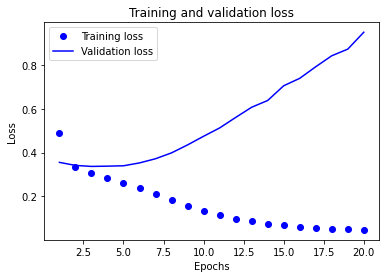

In [25]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

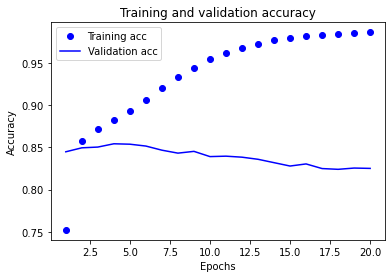

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 6-2. vec2 시각화

In [27]:
embeded_history_dict = embeded_history.history
print(embeded_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


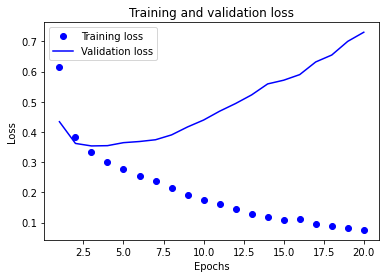

In [28]:
acc = embeded_history_dict['accuracy']
val_acc = embeded_history_dict['val_accuracy']
loss = embeded_history_dict['loss']
val_loss = embeded_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

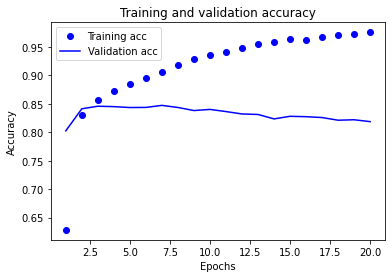

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 6-3. GlobalMaxPooling1D 시각화

In [30]:
gmp_history_dict = gmp_history.history

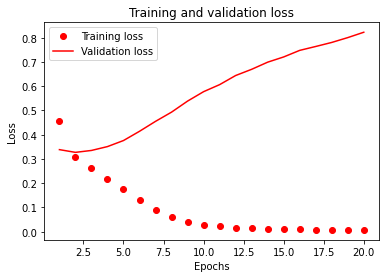

In [31]:
acc = gmp_history_dict['accuracy']
val_acc = gmp_history_dict['val_accuracy']
loss = gmp_history_dict['loss']
val_loss = gmp_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "빨간색"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

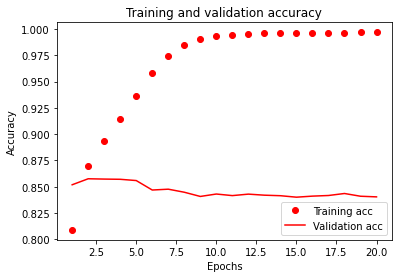

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7. 학습된 Embedding 레이어 분석

#### 7-1. 1D-CNN

In [23]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [24]:
import os
word_vector_dim = 16
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/09.RNN/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

#### 7-2. word2vec

In [25]:
embedding_layer = embeded_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [26]:
import os
word_vector_dim = 300
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
embeded_word2vec_file_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/09.RNN/embeded_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = embeded_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

#### 7-3. GlobalMaxPooling1D

In [27]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [28]:
import os
gmp_word_vector_dim = 300
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
gmp_word2vec_file_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/09.RNN/gmp_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([ 2.42419774e-03, -6.19815625e-02, -4.24698479e-02,  5.99643700e-02,
        7.68785737e-03,  1.21980369e-01, -1.22791128e-02,  5.24906628e-03,
        9.90284886e-03,  6.13907948e-02,  1.68179702e-02, -6.75243733e-04,
        1.39869705e-01, -6.28938153e-02, -4.12264653e-02,  6.45028725e-02,
        1.20679952e-01, -1.94853749e-02, -1.74204204e-02, -1.20254857e-02,
        1.16702162e-01, -6.71107844e-02, -4.98980395e-02, -5.12903705e-02,
        1.11393690e-01, -7.75011117e-03,  8.78404174e-03, -3.21959355e-03,
       -1.29972876e-03,  8.97761714e-03,  1.21095546e-01,  1.31974131e-01,
        9.89000574e-02,  1.34122133e-01,  1.42476305e-01, -4.77256961e-02,
       -2.24618204e-02,  3.58137563e-02, -1.26038725e-02, -6.00507334e-02,
       -4.24570478e-02, -4.02099863e-02,  1.57102440e-02,  5.65591045e-02,
        7.12803006e-02,  6.79732263e-02,  3.11740283e-02, -6.57114834e-02,
        2.10966449e-02,  2.91992426e-02, -3.74295227e-02, -1.00040995e-02,
        1.92062221e-02, -

In [30]:
word_vectors.similar_by_word("love")

[('따스', 0.6024826765060425),
 ('great', 0.6021842360496521),
 ('슬퍼요', 0.6019835472106934),
 ('아름다워요', 0.5805748701095581),
 ('잼따', 0.5718656778335571),
 ('조음', 0.5693366527557373),
 ('！', 0.5584565997123718),
 ('웰메이드', 0.5544450879096985),
 ('.♥', 0.55443274974823),
 ('홧팅', 0.5527105331420898)]

### 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [31]:
# 한국어 word2vec 다운받기 먼저
import gensim
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/workplace/aiffel/Exploration/09.RNN/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector     

/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [32]:
word2vec.similar_by_word("악마")

/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('사탄', 0.7450909614562988),
 ('천사', 0.7058097124099731),
 ('괴물', 0.6949796080589294),
 ('악령', 0.6667666435241699),
 ('요괴', 0.651904821395874),
 ('어둠', 0.646560788154602),
 ('방랑자', 0.6407898664474487),
 ('마녀', 0.6338205933570862),
 ('요정', 0.6273939609527588),
 ('마법사', 0.6268988847732544)]

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [34]:

from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [36]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 16s 59ms/step - loss: 0.5325 - accuracy: 0.7236 - val_loss: 0.4212 - val_accuracy: 0.8103
Epoch 2/20
266/266 [==============================] - 5s 20ms/step - loss: 0.3825 - accuracy: 0.8310 - val_loss: 0.3661 - val_accuracy: 0.8374
Epoch 3/20
266/266 [==============================] - 5s 20ms/step - loss: 0.3275 - accuracy: 0.8600 - val_loss: 0.3440 - val_accuracy: 0.8482
Epoch 4/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2957 - accuracy: 0.8769 - val_loss: 0.3476 - val_accuracy: 0.8488
Epoch 5/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2722 - accuracy: 0.8878 - val_loss: 0.3554 - val_accuracy: 0.8493
Epoch 6/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2514 - accuracy: 0.8983 - val_loss: 0.3543 - val_accuracy: 0.8503
Epoch 7/20
266/266 [==============================] - 5s 20ms/step - loss: 0.2331 - accuracy: 0.9074 - val_loss: 0.3648 - val_accuracy: 0.850

In [38]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.7775 - accuracy: 0.8303
[0.7774637937545776, 0.8302988409996033]


### 평가
변수명 대소문자 이슈 때문에 문제를 찾아가는데 시간이 많이 걸렸다. 컴퓨팅 사고가 익숙하지 않아서 생긴 문제이다. 데이터 크기 때문에 커널이 죽는 문제가 잦았다. 